In [34]:
import pandas as pd 
import numpy as np
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

#vizzing
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
#read all shots csv
df = pd.read_csv("./all_shots_final.csv")

In [48]:
#limit dataframe to 3 point FGs 
df3 = df[df['shot_type'] == '3PT Field Goal']
"shape of new dataframe df3:", df3.shape

('shape of new dataframe df3:', (28368, 24))

In [49]:
#combining mins and seconds remaining into one field (secocnds remaining)
df3['time_remain'] = df3['minutes_remaining'].multiply(60,'columns') + df3['seconds_remaining']
df3 = df3.drop(['minutes_remaining','seconds_remaining'],axis=1)
df3.columns

C:\Users\coreyjez\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Index([u'player_name', u'team_name', u'game_date_text', u'season',
       u'espn_player_id', u'team_id', u'espn_game_id', u'period',
       u'shot_made_flag', u'action_type', u'shot_type', u'shot_distance',
       u'opponent', u'x', u'y', u'dribbles', u'touch_time', u'defender_name',
       u'defender_distance', u'shot_clock', u'game_date', u'fg3_pct',
       u'time_remain'],
      dtype='object')

In [50]:
#classifying 3 point attempts based on their location (corner, wing, top of key)
df3['zone'] = 'wing'
df3['zone'][(df3['x']> -75) & (df3['x'] <75)] = 'key'
df3['zone'][df3['y'] < 100] = 'corner'

C:\Users\coreyjez\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\coreyjez\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [51]:
#getting rid of columns we don't need: player_id, team_id, game_id 
df3 = df3.drop(['espn_player_id','team_id','espn_game_id','shot_type','game_date','season','x','y','game_date_text'],axis=1)

In [52]:
df3.fg3_pct = df3.fg3_pct.round(decimals=2)

In [53]:
#replacing the null defender fields with a name of 'Unknown'
df3.defender_name = df3.defender_name.fillna('unknown')

#replacing the null 3point FG rates with a 0 
df3.fg3_pct = df3.fg3_pct.fillna(0)

In [54]:
df3.shot_made_flag.value_counts()

0    18489
1     9879
Name: shot_made_flag, dtype: int64

In [55]:
#binary encode the categorical columns: name, team_name, action_type, opponent, defender_name 
enc_df3 = ce.BinaryEncoder(cols=['player_name','team_name','action_type','opponent','defender_name','zone']).fit_transform(df3)

In [56]:
#lets try a super basic logreg model to see how it works
X = enc_df3.drop('shot_made_flag',axis=1)
y = enc_df3['shot_made_flag']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

print "size of training data:",X_train.shape
print "size of test data:",X_test.shape

size of training data: (19857, 42)
size of test data: (8511, 42)


In [57]:
log = LogisticRegression()

#train
log.fit(X_train,y_train)


#training set preds
log_train_preds = log.predict(X_train)

#test set preds
log_test_preds = log.predict(X_test)

In [58]:
#lets see how the model fit 
test_auc_log = metrics.roc_auc_score(y_test,log_test_preds)
print "log auc score:", test_auc_log

log auc score: 0.506982160167


In [59]:
#ok lets run a random forest and see what we come up with
from sklearn.ensemble import RandomForestClassifier

In [60]:
X_rf = X
y_rf = y

X_rf_train,X_rf_test,y_rf_train,y_rf_test = train_test_split(X_rf,y_rf,test_size = 0.3)

rf = RandomForestClassifier(n_estimators=100,max_depth=20,bootstrap=True,n_jobs=-1)

#train 
rf.fit(X_rf_train,y_rf_train)

#training set preds
rf_train_preds = rf.predict(X_rf_train)

#test set preds
rf_test_preds = rf.predict(X_rf_test)

In [62]:
names = X.columns
imp= sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)
imp

[(0.1148, 'time_remain'),
 (0.106, 'shot_clock'),
 (0.0834, 'fg3_pct'),
 (0.0788, 'touch_time'),
 (0.0496, 'shot_distance'),
 (0.0375, 'period'),
 (0.0246, 'dribbles'),
 (0.0191, 'defender_name_7'),
 (0.0188, 'opponent_2'),
 (0.0186, 'defender_name_8'),
 (0.0186, 'defender_name_2'),
 (0.0185, 'opponent_3'),
 (0.0185, 'defender_name_4'),
 (0.0183, 'defender_name_6'),
 (0.0183, 'defender_name_3'),
 (0.0182, 'opponent_4'),
 (0.018, 'opponent_0'),
 (0.0179, 'defender_name_5'),
 (0.0176, 'player_name_7'),
 (0.0176, 'opponent_1'),
 (0.0173, 'player_name_6'),
 (0.0171, 'player_name_4'),
 (0.0169, 'team_name_4'),
 (0.0168, 'player_name_1'),
 (0.0167, 'team_name_3'),
 (0.0167, 'player_name_8'),
 (0.0167, 'player_name_5'),
 (0.0164, 'team_name_1'),
 (0.0163, 'team_name_0'),
 (0.0163, 'defender_name_0'),
 (0.0162, 'player_name_2'),
 (0.0162, 'defender_name_1'),
 (0.0157, 'player_name_3'),
 (0.0153, 'team_name_2'),
 (0.0146, 'zone_0'),
 (0.0091, 'zone_1'),
 (0.0051, 'action_type_3'),
 (0.0043, 'ac

In [61]:
test_auc_rf = metrics.roc_auc_score(y_rf_test,rf_test_preds)
print "Standard RF auc:",test_auc_rf

Standard RF auc: 0.51155423


In [63]:
rf_test_probs = rf.predict_proba(X_rf_test)[:,1]

#plot roc curve
def plot_roc (test_probs, y_test, titlestr):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    y_test = y_rf_test 
    y_rf_score = rf_test_probs
    
    fpr, tpr, _ = roc_curve(y_test,y_rf_score)
    roc_auc = auc(fpr,tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label = 'Roc Curve (area = %0.4f)' %roc_auc)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(titlestr)
    plt.legend(loc="lower right")
    plt.show()

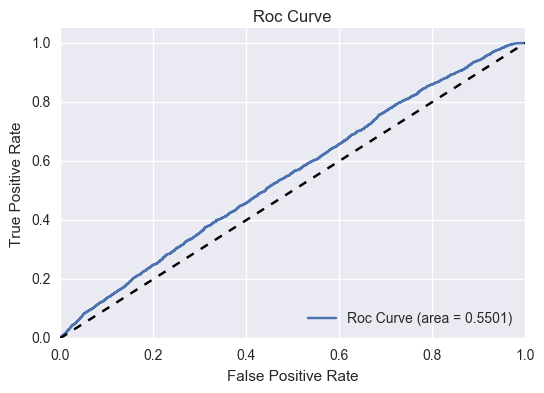

In [64]:
plot_roc(rf_test_probs,y_test,'Roc Curve')

In [40]:
#lets see if we can optimize the RF
estimator_range = range(10,500,10)

auc_scores = []

for estimator in estimator_range:
    rftune = RandomForestClassifier(n_estimators=estimator,bootstrap=True,oob_score=True,n_jobs=-1)
    rftune.fit(X_rf_train,y_rf_train)
    tune_preds = rftune.predict(X_rf_test)
    auc = metrics.roc_auc_score(y_rf_test,tune_preds)
    auc_scores.append(auc)

C:\Users\coreyjez\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


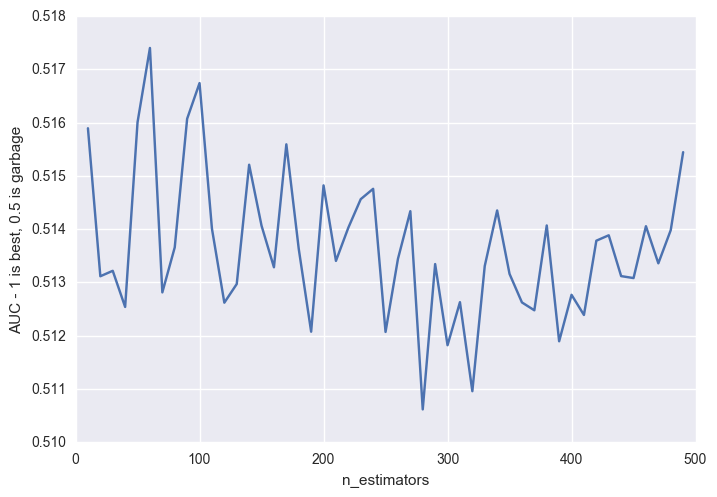

In [41]:
plt.plot(estimator_range,auc_scores)
plt.xlabel('n_estimators')
plt.ylabel('AUC - 1 is best, 0.5 is garbage')